# Stroke analysis script

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as st
import os
import pickle

parcellation = 'Sch240'
n_connectomes = '20'
behaviour_list = ['APM','NART_IQ','Q1_TotalWords','Q6_TotalCorrect','CoC_abs_rev']
normalise_behav = True
reverse_behav = True
regress_size = False
CCApermutations = 1000
MCA_components = 5
CCA_components = 5
outdir = '/Users/luke/Documents/Projects/StrokeNet/Docs/Figures/2020/'

# Load data

In [3]:
behav_df, CM, NIFTI = st.load_data(parcellation=parcellation,
                         n_connectomes=n_connectomes,
                         behaviour_list=behaviour_list)

MNIcoords, networks, network_labels = st.get_atlas_info(parcellation=parcellation)

136it [00:06, 21.10it/s]
80it [00:17,  4.53it/s]


### Behaviour plot

[[ 1.          0.23865773  0.41317585  0.20543987  0.34704538]
 [ 0.23865773  1.          0.45512201  0.33680595 -0.00802103]
 [ 0.41317585  0.45512201  1.          0.38843011  0.23956493]
 [ 0.20543987  0.33680595  0.38843011  1.          0.05731903]
 [ 0.34704538 -0.00802103  0.23956493  0.05731903  1.        ]]


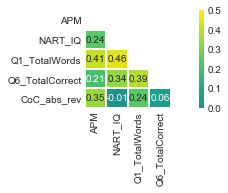

In [4]:
labels = behaviour_list
data = behav_df[behaviour_list].values
st.plotting_tools.behav_heatmap(data,labels,title=outdir+'behav_corr_plot.svg')

In [5]:
# # do fdr correction on behaviour
# from scipy.stats import spearmanr
# from statsmodels.stats.multitest import multipletests
# r,p = spearmanr(data)
# # rank correlation between behavioural variables
# corr = spearmanr(data)[0]

# mask = np.zeros_like(corr)
# mask[np.tril_indices_from(mask,k=-1)] = True
# p_vals = p[mask>0]
# print(p_vals)
# p_adj = multipletests(p_vals,method='fdr_bh')[1]
# print(p_adj<0.05)

### Lesion distribution plots

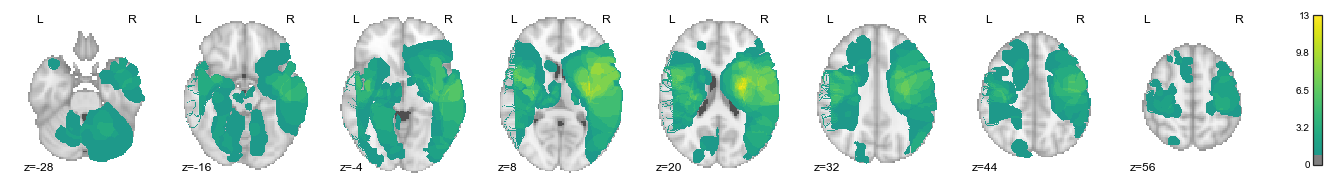

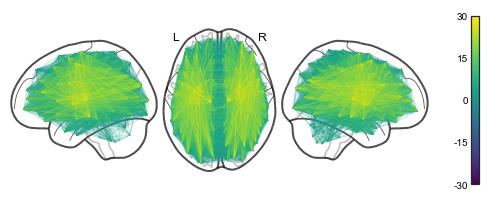

In [6]:
st.plotting_tools.lesion_dist_nii(NIFTI,title=outdir+'lesion_dist.svg') # consider loading in the original nifti rather than resized for better image
st.plotting_tools.lesion_dist_cm(CM['Diff'],MNIcoords=MNIcoords,vmin=-30,title=outdir+'lesion_conn_dist.jpeg')

### Demographics

In [7]:
do_demographics=0
if do_demographics:
    for meas in ['Age','Education','Chronicity','NART_IQ','APM','Q1_TotalWords','Q6_TotalCorrect','CoC_abs_rev']:
        print(meas)
        print('\tMean =',np.round(np.mean(behav_df[meas]),2))
        #print('\tMedian =',np.round(np.median(behav_df[meas]),2))
        print('\tStd =',np.round(np.std(behav_df[meas]),2))
        print('\tmin =',np.round(np.min(behav_df[meas]),2))
        print('\tmax =',np.round(np.max(behav_df[meas]),2))
        plt.hist(behav_df[meas])
        plt.show()

# Connectivity based analyses

## Multiple correspondance analysis (MCA)
- 'X' is the connectivity data variable
- 'mca.ind_weights' is the data when reduced to 10 components

In [8]:
# reshape connectivity data
n_subs = np.shape(CM['Diff'])[2]
n_nodes = np.shape(CM['Diff'])[0]
n_edges = np.int((n_nodes*(n_nodes-1))/2)
print('Subjects=',n_subs,', nodes=',n_nodes,', edges=',n_edges)

X_full = np.zeros((n_subs,n_edges))
index_upper = np.triu_indices(n_nodes, k=1)
for subj in range(n_subs):
    data = CM['Diff'][:,:,subj].copy()
    X_full[subj,:] = data[index_upper].copy()

# binarize edges
X_full = X_full > 0

# remove non informative features
keep_features = np.sum(X_full,axis=0)>3
X = X_full[:,keep_features]
print('Edges included=',np.sum(keep_features))
print('Calculating MCA...')
mca = st.do_MCA(X,n_components=MCA_components)
mca.keep_features = keep_features
print('Finished MCA!')

# put MCA edges into connectivity matrix space
mca.edge_scores_mat = np.zeros((n_nodes,n_nodes,MCA_components))
for i in range(MCA_components):
    data = np.zeros((len(mca.keep_features)))
    data[mca.keep_features] = mca.edge_scores[:,i]
    data_mat = np.zeros((n_nodes,n_nodes))
    data_mat[index_upper] = data
    mca.edge_scores_mat[:,:,i] = data_mat
print('Eigenvalues=',np.round(mca.eigenvalues_,4))
print('Sum of eigenvalues=',np.round(np.sum(mca.eigenvalues_),4))

Subjects= 80 , nodes= 240 , edges= 28680
Edges included= 7779
Calculating MCA...
Finished MCA!
Eigenvalues= [0.239  0.1043 0.0564 0.0497 0.0355]
Sum of eigenvalues= 0.4849


## Canonical correlation analysis (CCA)


In [29]:
y = behav_df[behaviour_list].values

if normalise_behav:
    #y = st.vanderWaerden_transform(y)
    #y = zscore(y,axis=0)
    y=quantile_transform(y,axis=0)
if reverse_behav:
    y = y*-1 
if regress_size:
    # find the size of each lesion
    s = np.sum(np.sum(np.sum(NIFTI,axis=0),axis=0),axis=0)
    
    # use regress to get the residual
    _betas,y = st.regression(y,s.reshape(len(s),-1))

# do cca
cca,p_adj = st.do_cca(mca.ind_scores,y,X,n_components=CCA_components,permutations=CCApermutations)
print('Raw LCr values=',np.round(cca.mode_r,2))
print('Padj for modes=',p_adj)

# put CCA weights back in original space
cca.x_weights_mat = np.zeros((n_nodes,n_nodes,CCA_components))
for i in range(CCA_components):
    data = np.zeros((len(keep_features)))
    data[keep_features] = cca.x_score_correlation[:,i]
    data_mat = np.zeros((n_nodes,n_nodes))
    data_mat[index_upper] = data
    cca.x_weights_mat[:,:,i] = data_mat
    
    # save cca out for graph and neurosynth analysis
    np.savetxt('cca_weights_mat_mode'+str(i)+'.csv',cca.x_weights_mat[:,:,i],delimiter=',')

100%|██████████| 1000/1000 [00:03<00:00, 252.06it/s]


Raw LCr values= [0.67 0.42 0.28 0.1  0.06]
Padj for modes= [0.0, 0.404, 0.992, 1.0, 1.0]


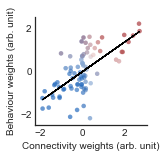

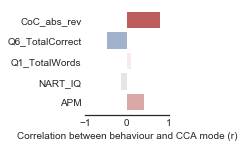

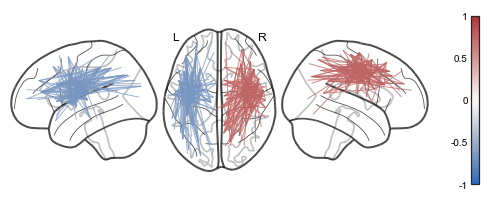

In [30]:
# cca plots (mode 1)
st.CCA_UV_plot(cca,title=outdir+'CCA_UV_mode1.svg')
st.CCA_behav_plot(cca,labels=behaviour_list,title=outdir+'CCA_beh_mode1.svg')
st.CCA_cm_brain_plot(cca,MNIcoords,num_edge=250,mode=0,title=outdir+'CCA_brain_mode1.svg')

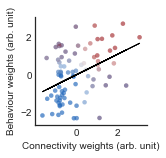

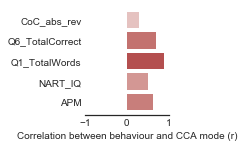

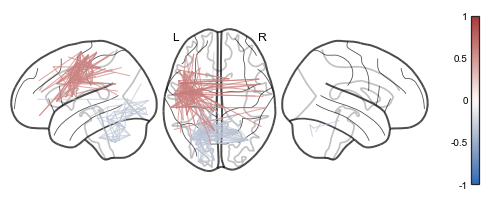

In [31]:
# cca plots (mode 2)
st.CCA_UV_plot(cca,mode=1)
st.CCA_behav_plot(cca,labels=behaviour_list,mode=1)
st.CCA_cm_brain_plot(cca,MNIcoords,num_edge=200,mode=1)

## Network affiliation analysis

In [ ]:
import matplotlib.patches as patches
def network_plot(network_mean,network_labels,p_mat,mode=0,title=None,vmin=0,vmax=0.55):
    
    data = network_mean[:,:,mode]
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask,k=1)] = True
    plt.figure(figsize=(3.125,2.5))
    ax = sns.heatmap(abs(data),
                vmin=vmin,
                vmax=vmax,
                cmap='viridis',
                annot=False,
                fmt='.2f',
                mask=mask,
                linewidths=1,
                xticklabels=network_labels,
                yticklabels=network_labels)

    # draw significance
    for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                if i > j:
                    continue
                if p_mat[i,j,mode]==True:
                    # Create a Rectangle patch
                    rect = patches.Rectangle((i,j),1,1,linewidth=1.5,edgecolor='r',facecolor='none')

                    # Add the patch to the Axes
                    ax.add_patch(rect)
     # draw signifcance legend
    rect = patches.Rectangle((4,1),1,1,linewidth=1.5,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    
    if title is not None:
        plt.savefig(title,dpi=600)
    plt.show()

In [ ]:
network_mean, p_fwe = st.net_affilation_wrapper(cca.x_weights_mat,CCA_components,networks,permutations=1000)


In [ ]:
network_plot(network_mean,network_labels,p_fwe < 0.05,title=outdir+'CCA_mean_nets_mode1.svg')

In [ ]:
# MNIcoords, networks, network_labels = st.get_atlas_info(parcellation=parcellation)
# network_mean = st.network_affilation_cm(cca,CCA_components,networks)
# st.network_plot(network_mean,network_labels,vmax=0.50,mode=0)

## Cross validated prediction

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cross_decomposition import CCA
from scipy.stats import spearmanr
from tqdm import tqdm

def cv_cca(X,y,iterations=100,num_cvs=5):
    cv = KFold(n_splits=num_cvs,shuffle=True)
    #y_pred = np.zeros((np.shape(y)))

    r_avg = np.zeros((iterations,np.shape(y)[1]))
    rs_avg = r_avg.copy()
    MAE_avg = r_avg.copy()
    Rsqr_avg = r_avg.copy()
    
    for j in tqdm(range(iterations)):
        
        r = np.zeros((num_cvs,np.shape(y)[1]))
        rs = r.copy()
        MAE = r.copy()
        Rsqr = r.copy()
        
        cv_count = 0
        for train_index, test_index in cv.split(X):
            #organise the data into training and testing sets
            X_train = X[train_index,:]
            y_train = y[train_index,:]
            X_test  = X[test_index,:]

            # do cca
            cv_cca = CCA(n_components=1)
            cv_cca.fit(X_train,y_train)

            # predict left out values
            y_pred = cv_cca.predict(X_test)

            # save predictions for this cv
            for i in range(np.shape(y)[1]):
                r[cv_count,i] = np.corrcoef(y[test_index,i],y_pred[:,i])[0,1]
                rs[cv_count,i] = spearmanr(y[test_index,i],y_pred[:,i])[0]
                MAE[cv_count,i] = mean_absolute_error(y[test_index,i],y_pred[:,i])
                Rsqr[cv_count,i] = r2_score(y[test_index,i],y_pred[:,i])
            cv_count = cv_count+1 
            
        # average predictions for this iteration
        r_avg[j,:] = np.mean(r,axis=0)
        rs_avg[j,:] = np.mean(rs,axis=0)
        MAE_avg[j,:] = np.mean(MAE,axis=0)
        Rsqr_avg[j,:] = np.mean(Rsqr,axis=0)
    return r_avg,rs_avg,MAE_avg,Rsqr_avg

In [ ]:
from sklearn.utils import shuffle
cv_conn_r,cv_conn_rs,cv_conn_MAE,cv_conn_Rsqr = cv_cca(mca.ind_scores,y,iterations=cv_iterations)
# create a null model
#_,cv_conn_MAE_NULL,_ = cv_cca(mca.ind_scores,shuffle(y),iterations=cv_iterations*10)

# Exploratory interhemispheric connectivity analysis
- Only include interhemispheric connections

In [ ]:
# # generate an interhemispheric index array
# # reshape connectivity data
# n_subs = np.shape(CM['Diff'])[2]
# n_nodes = np.shape(CM['Diff'])[0]
# n_edges = np.int((n_nodes*(n_nodes-1))/2)
# interhemispheric_index = np.zeros((n_nodes,n_nodes))

# for i in range(len(MNIcoords)):
#     roi = MNIcoords[i,0]
#     if roi < 0:
#         interhemispheric_index[i,MNIcoords[:,0] > 0] = np.int(1)
#     if roi > 0:
#         interhemispheric_index[i,MNIcoords[:,0] < 0] = np.int(1)

# plt.figure(figsize=(2,2))
# plt.imshow(interhemispheric_index,aspect='auto')
# plt.show()
# interhemispheric_index = np.where(interhemispheric_index==0)

## MCA

In [ ]:
# # reshape connectivity data
# X_full = np.zeros((n_subs,n_edges))
# index_upper = np.triu_indices(n_nodes, k=1)
# for subj in range(n_subs):
#     data = CM['Diff'][:,:,subj].copy()
#     data[interhemispheric_index] = 0
#     X_full[subj,:] = data[index_upper].copy()

# # binarize edges
# X_full = X_full > 0

# # remove non informative features
# keep_features = np.sum(X_full,axis=0)>0
# X = X_full[:,keep_features]

# print('Calculating MCA...')
# mca = st.do_MCA(X,n_components=MCA_components)
# print('Finished MCA!')

# # put MCA edges into connectivity matrix space
# mca.edge_scores_mat = np.zeros((n_nodes,n_nodes,MCA_components))
# for i in range(MCA_components):
#     data = np.zeros((len(keep_features)))
#     data[keep_features] = mca.edge_scores[:,i]
#     data_mat = np.zeros((n_nodes,n_nodes))
#     data_mat[index_upper] = data
#     mca.edge_scores_mat[:,:,i] = data_mat

In [ ]:
# MCA plots
st.MCA_cm_plots(mca,MCA_components,MNIcoords=MNIcoords,num_edge=250,title=None)

## CCA

In [ ]:
# y = behav_df[behaviour_list].values

# if normalise_behav:
#     y = st.vanderWaerden_transform(y)

# # do cca
# cca,p_adj = st.do_cca(mca.ind_scores,y,X,n_components=CCA_components,permutations=CCApermutations)
# print('Raw LCr values=',np.round(cca.mode_r,2))
# print('Pvalues for components=',p_adj)

# # put CCA weights back in original space
# cca.x_weights_mat = np.zeros((n_nodes,n_nodes,CCA_components))
# for i in range(2):
#     data = np.zeros((len(keep_features)))
#     data[keep_features] = cca.x_score_correlation[:,i]
#     data_mat = np.zeros((n_nodes,n_nodes))
#     data_mat[index_upper] = data
#     cca.x_weights_mat[:,:,i] = data_mat

In [ ]:
# # cca plots
# st.CCA_UV_plot(cca)
# st.CCA_behav_plot(cca,labels=behaviour_list)
# st.CCA_cm_brain_plot(cca,MNIcoords)

## Network affiliations

In [ ]:
# MNIcoords, networks, network_labels = st.get_atlas_info(parcellation=parcellation)
# network_mean = st.network_affilation_cm(cca,CCA_components,networks)
# st.network_plot(network_mean,network_labels)

# Voxel based analyses
Uses a lot of memory! Runs out if voxel lesion inclusion is low when correlating with weights in the CCA...

## MCA

In [ ]:
# which voxels to include when thresholding across participants
# ideally '0' but runs quite slow.
voxel_lesion_inclusion = 4

#check if MCA file already exists (very slow to ru)
file = '/Users/luke/Documents/Projects/StrokeNet/Data/MCA/voxel_MCA_results_thresh_'+str(voxel_lesion_inclusion)+'.pkl'
if os.path.isfile(file):
    print('Loading voxelwise MCA data...')
    mca = pickle.load(open(file,'rb'))
    print('Features included=',np.sum(mca.keep_features))

else:    
    # reshape connectivity data
    n_subs = np.shape(NIFTI)[3]
    n_voxels = np.int(np.shape(NIFTI)[0]*np.shape(NIFTI)[1]*np.shape(NIFTI)[2])
    print('Subjects=',n_subs,', voxels=',n_voxels)

    X_full = np.zeros((n_subs,n_voxels))
    for subj in range(n_subs):
        data = NIFTI[:,:,:,subj].copy()
        data = np.reshape(data,[n_voxels],order='C')
        X_full[subj,:] = data.copy()

    # binarize edges
    X_full = X_full > 0

    # remove non informative features
    keep_features = np.sum(X_full,axis=0)>voxel_lesion_inclusion
    X = X_full[:,keep_features]
    print('Features included=',np.sum(keep_features))
    print('Calculating MCA...')
    mca = st.do_MCA(X,n_components=MCA_components)
    print('Finished MCA!')

    # reshape data 
    dims = np.shape(NIFTI)
    mca.edge_scores_mat = np.zeros((dims[0],dims[1],dims[2],MCA_components))
    for i in range(MCA_components):
        data = np.zeros((len(keep_features)))
        data[keep_features] = mca.edge_scores[:,i]
        data_mat = np.zeros((dims[0],dims[1],dims[2]))
        data_mat = np.reshape(data,np.shape(data_mat),order='C')
        mca.edge_scores_mat[:,:,:,i] = data_mat
    print('Eigenvalues=',np.round(mca.eigenvalues_,4))
    print('Sum of eigenvalues=',np.round(np.sum(mca.eigenvalues_),4))

    # save data out
    mca.keep_features = keep_features.copy()
    mca.X = X
    pickle.dump(mca,open(file,'wb'))

In [ ]:
from nilearn import plotting
import nibabel as nib

affine = np.array([[  -1.,    0.,    0.,   90.],
       [   0.,    1.,    0., -126.],
       [   0.,    0.,    1.,  -72.],
       [   0.,    0.,    0.,    1.]])

for component in range(MCA_components):
    array_data = mca.edge_scores_mat[:,:,:,component]
    img = nib.Nifti1Image(array_data, affine)
    plotting.plot_stat_map(img,cmap='viridis',display_mode='z',colorbar=True)
    plt.title(np.round(mca.eigenvalues_[component],2))
    plt.show()

## CCA

In [ ]:
y = behav_df[behaviour_list].values

if normalise_behav:
    y = st.vanderWaerden_transform(y)
if reverse_behav:
    y = y*-1
    
# do cca
cca,p_adj = st.do_cca(mca.ind_scores,y,mca.X,n_components=CCA_components,permutations=CCApermutations)
print('Raw LCr values=',np.round(cca.mode_r,2))
print('Pvalues for components=',p_adj)

# reshape data 
dims = np.shape(NIFTI)
cca.x_weights_mat = np.zeros((dims[0],dims[1],dims[2],CCA_components))
for i in range(2):
    data = np.zeros((len(mca.keep_features)))
    data[mca.keep_features] = cca.x_score_correlation[:,i]
    data_mat = np.zeros((dims[0],dims[1],dims[2]))
    data_mat = np.reshape(data,np.shape(data_mat),order='C')
    cca.x_weights_mat[:,:,:,i] = data_mat

In [ ]:
# cca plots
st.CCA_UV_plot(cca)
st.CCA_behav_plot(cca,labels=behaviour_list)
st.CCA_nifti_brain_plot(cca)

In [ ]:
# cca plots
st.CCA_UV_plot(cca,mode=1)
st.CCA_behav_plot(cca,labels=behaviour_list,mode=1)
st.CCA_nifti_brain_plot(cca,mode=1)

In [ ]:
cv_vox_r,cv_vox_rs,cv_vox_MAE,cv_vox_Rsqr = cv_cca(mca.ind_scores,y,iterations=cv_iterations)
# create a null model
#_,cv_vox_MAE_NULL,_ = cv_cca(mca.ind_scores,shuffle(y),iterations=cv_iterations*10)

# Model comparison

## Connectivity

In [ ]:
from functions.remove_border import remove_border
def custom_boxplot(x,boxcolor,position,boxwidth):
    # box plot
    # horizontal lines
    for i in [25,50,75]:
        value = np.percentile(x, i)
        plt.plot([position - boxwidth/2, position + boxwidth/2],[value, value],color=boxcolor)
        plt.plot([position - boxwidth/2, position + boxwidth/2],[value, value],color=boxcolor)

    # vertical lines
    plt.plot([position - boxwidth/2, position - boxwidth/2],[np.percentile(x, 25),np.percentile(x, 75)],color=boxcolor)
    plt.plot([position + boxwidth/2, position + boxwidth/2],[np.percentile(x, 25),np.percentile(x, 75)],color=boxcolor)
    # whiskers
    plt.plot([position,position],[np.percentile(x, 25),np.percentile(x,5)],color=boxcolor)
    plt.plot([position,position],[np.percentile(x, 75),np.percentile(x,95)],color=boxcolor)
    
def two_group_box_and_scatter(x,y,alpha=0.25,width=0.25,boxwidth=0.3):
    
    #group 1
    position = 0
    # scatter plot 
    jitter = np.random.rand(len(x)) * width + position - width/2
    plt.scatter(jitter,x,alpha=alpha)
    custom_boxplot(x,'k',position=position,boxwidth=boxwidth)
    
    #group 2
    position = 1
    # scatter plot 
    jitter = np.random.rand(len(y)) * width + position - width/2
    plt.scatter(jitter,y,alpha=alpha)
    custom_boxplot(y,'k',position=position,boxwidth=boxwidth)
    remove_border()

In [ ]:
plt.figure(figsize=(17/2.54,3))
for i,label in enumerate(behaviour_list):
    plt.subplot(1,5,i+1)
    plt.title(label)
    two_group_box_and_scatter(cv_vox_MAE[:,i],cv_conn_MAE[:,i],alpha=0.10,width=0.25,boxwidth=0.75)
    plt.xticks([0,1],['Voxel','Conn'],rotation=30)

plt.suptitle('MAE',fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(17/2.54,3))
for i,label in enumerate(behaviour_list):
    plt.subplot(1,5,i+1)
    plt.title(label)
    two_group_box_and_scatter(cv_vox_rs[:,i],cv_conn_rs[:,i],alpha=0.10,width=0.25,boxwidth=0.75)
    plt.xticks([0,1],['Voxel','Conn'],rotation=30)

plt.suptitle('Spearman r',fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

plt.figure(figsize=(17/2.54,3))
for i,label in enumerate(behaviour_list):
    plt.subplot(1,5,i+1)
    plt.title(label)
    two_group_box_and_scatter(cv_vox_Rsqr[:,i],cv_conn_Rsqr[:,i],alpha=0.10,width=0.25,boxwidth=0.75)
    plt.xticks([0,1],['Voxel','Conn'],rotation=30)

plt.suptitle('R squared',fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
## Comparison
from scipy import stats
print('MAE val')
for i in range(5):
    print('\t',stats.ttest_ind(cv_vox_MAE[:,i],cv_conn_MAE[:,i]))
print('')
print('R val')
for i in range(5):
    print('\t',stats.ttest_ind(cv_vox_r[:,i],cv_conn_r[:,i]))
print('')
print('Grand Means:')
print('\tMAE con:',np.mean(cv_conn_MAE))
print('\tMAE vox:',np.mean(cv_vox_MAE))
print('\tr con:',np.mean(cv_conn_r))
print('\tr vox:',np.mean(cv_vox_r))

In [ ]:
np.mean(cv_vox_MAE)